In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import tensorflow as tf
from tensorflow.keras import layers
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc')
octave.addpath(eeglab_path + 'popfunc')
octave.addpath(eeglab_path + 'adminfunc')
octave.addpath(eeglab_path + 'sigprocfunc')
octave.addpath(eeglab_path + 'miscfunc')

'.:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/sigprocfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/adminfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/popfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/guifunc:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/oct2py:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/octave_kernel:/usr/lib/x86_64-linux-gnu/octave/4.2.2/site/oct/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/api-v51/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/site/m:/usr/share/octave/site/api-v51/m:/usr/share/octave/site/m:/usr/share/octave/site/m/startup:/usr/lib/x86_64-linux-gnu/octave/4.2.2/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/m:/usr/share/octave/4.2.2/m/audio:/usr/share/octave/4.2.2/m/debian:/usr/share/octave/4.2.2/m/deprecated:/usr/share/octave/4.2.2/m/elfun:/usr/share/octave/4.2.2/m/general:/usr/share/octave/4.2

In [3]:
experiment = 'data/original/*/*'
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean-prestimulus.set'))
eeg_present = len(eegs) > 0
cmaps = sorted(glob.glob(experiment + '/cmap/*.xlsx'))
cmap_present = len(cmaps) > 0
all_present = mep_present and eeg_present and cmap_present
print(all_present)

True


In [4]:
print('EEG count: ' + str(len(eegs)))
print('MEP count: ' + str(len(meps)))
print('CMAP count: ' + str(len(cmaps)))

EEG count: 44
MEP count: 77
CMAP count: 22


In [5]:
eegs

['data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp02/eeg/SP 120RMT r2/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP

In [6]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set', NO CMAP
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
#     'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set', LEFT HANDED
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r3/clean-prestimulus.set'
]

# Read and process EEG

In [7]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

# Calculate EEG area.
def calculate_eeg_area(epoch_df, sf=2048):
    y = epoch_df.drop('time', axis=1).mean(axis=1)
    b2, a2 = signal.butter(4, 200/(sf/2), btype='lowpass')
    envelope = signal.filtfilt(b2, a2, np.abs(y))
    area = np.trapz(envelope, epoch_df['time'].values)
    return area

# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 2048
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

def band_max(freq, psd, interval):
    indices = []
    for el in freq:
        indices.append(el in interval)
    freq = freq[indices]
    psd = psd[indices]
    if (len(psd) == 0):
        return 0, 0
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

def read_wavelets(sub, exp, run, epoch_num):
    path = 'wavelets/' + sub + '-' + exp + '-' + run + '-' + str(epoch_num)
    with open(path + '-central.pickle', 'rb') as f:
        central = pickle.load(f)
    with open(path + '-ltm1.pickle', 'rb') as f:
        ltm1 = pickle.load(f)
    with open(path + '-rtm1.pickle', 'rb') as f:
        rtm1 = pickle.load(f)
    with open(path + '-all.pickle', 'rb') as f:
        all_channels = pickle.load(f)
    return all_channels, ltm1, rtm1, central

def wavelet_band_max(df, interval):
    indices = []
    for el in (df.index * 1000):
        indices.append(el in interval)
    df = df[indices]
    if (df.shape[0] == 0):
        return 0, 0, 0, 0
    return df.mean(axis=1).max(), df.mean(axis=1).argmax() * 1000, df.mean(axis=0).max(), df.mean(axis=0).argmax()

# Read features file

In [8]:
features_filename = '55-features-v1.xlsx'

In [9]:
df = pd.read_excel(features_filename, index_col=0)

p1 = np.percentile(df['mep_category_cmap'], 50)
cat = np.ones(len(df['mep_category_cmap'])) * (df['mep_category_cmap'] > p1)
df['mep_category_cmap_across_subjects'] = cat

# Prepare wavelet dataframe

In [10]:
def normalize_image(image, mx=1, mn=0):
    wt_min = image.min().min()
    std = (image.values - wt_min) / (image.max().max() - wt_min)
    image.loc[:, :] = std * (mx - mn) + mn
    return image

In [11]:
start_time_sec = -500
end_time_sec = -20

df_wt = []
df_mean = np.zeros((37,983))
for idx, epoch in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    wt_all, wt_ltm1, wt_rtm1, wt_central = read_wavelets(epoch['sub'], epoch['exp'], epoch['run'], epoch['epoch'])

    # Take 6-50Hz frequencies.
#     wt_all = wt_all[(wt_all.index * 1000 > 6) * (wt_all.index * 1000 < 50)]
    wt_ltm1 = wt_ltm1[(wt_ltm1.index * 1000 > 2) * (wt_ltm1.index * 1000 < 50)]
#     wt_rtm1 = wt_rtm1[(wt_rtm1.index * 1000 > 6) * (wt_rtm1.index * 1000 < 50)]
#     wt_central = wt_central[(wt_central.index * 1000 > 6) * (wt_central.index * 1000 < 50)]

    # Take only last -100ms to -20ms.
#     wt_all = wt_all.loc[:, wt_all.columns.isin(wt_all.columns[(wt_all.columns >= (start_time_sec/1000)) * (wt_all.columns <= (end_time_sec/1000))])]
    wt_ltm1 = wt_ltm1.loc[:, wt_ltm1.columns.isin(wt_ltm1.columns[(wt_ltm1.columns >= (start_time_sec/1000)) * (wt_ltm1.columns <= (end_time_sec/1000))])]
#     wt_rtm1 = wt_rtm1.loc[:, wt_rtm1.columns.isin(wt_rtm1.columns[(wt_rtm1.columns >= (start_time_sec/1000)) * (wt_rtm1.columns <= (end_time_sec/1000))])]
#     wt_central = wt_central.loc[:, wt_central.columns.isin(wt_central.columns[(wt_central.columns >= (start_time_sec/1000)) * (wt_central.columns <= (end_time_sec/1000))])]
    
    norm = normalize_image(wt_ltm1)
    df_wt.append(norm)
    df_mean = np.add(df_mean, norm.values)

In [12]:
df_wt[5].shape

(37, 983)

Text(0.5, 1, 'Mean of all')

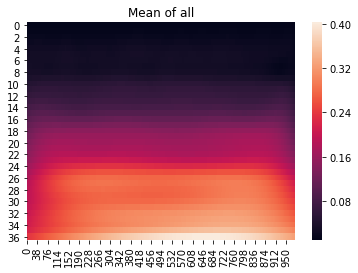

In [13]:
df_mean = df_mean / df.shape[0]
plt.figure()
sns.heatmap(df_mean)
plt.title('Mean of all')

Text(0.5, 1, '55th epoch wavelet')

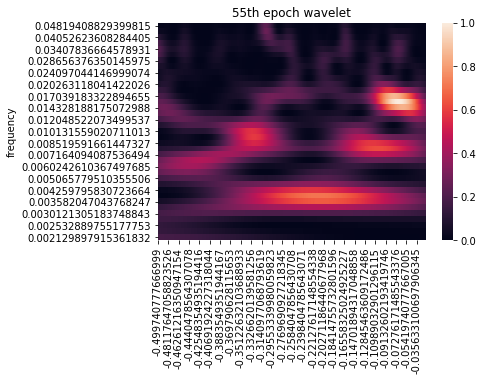

In [14]:
plt.figure()
sns.heatmap(df_wt[55])
plt.title('55th epoch wavelet')

In [15]:
df_wt2 = []
for wt in tqdm_notebook(df_wt):
    df_wt2.append(normalize_image(np.add(wt, -df_mean)))
df_wt = df_wt2

Text(0.5, 1, '55th epoch wavelet after subtraction')

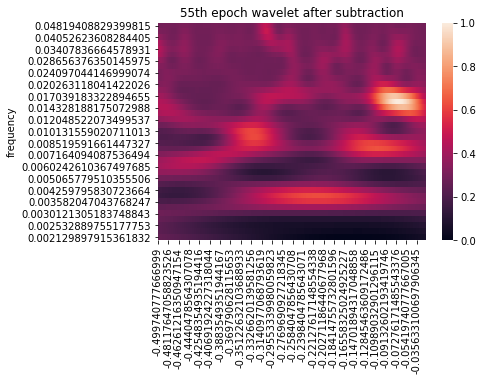

In [16]:
plt.figure()
sns.heatmap(df_wt[55])
plt.title('55th epoch wavelet after subtraction')

In [17]:
df_wt[5].shape

(37, 983)

# Keras

In [18]:
x = []
for wt in df_wt:
    img = np.array(wt.values)
    img = resize(img, (32, 32))
    x.append(img.reshape(img.shape[0], img.shape[1], 1))
    
x = np.array(x)
y = cat.values

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [19]:
x[0].shape

(32, 32, 1)

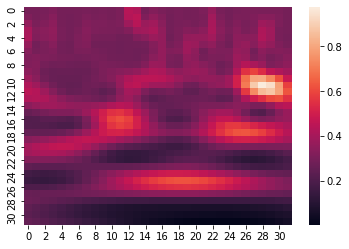

In [20]:
plt.figure()
sns.heatmap(x[55][:, :, 0])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=28)

In [22]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.4]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.00001]))
HP_CNN_FILTER_1 = hp.HParam('filter_1', hp.Discrete([8, 32, 64]))
HP_CNN_FILTER_2 = hp.HParam('filter_2', hp.Discrete([8, 32, 64]))
HP_BATCH_NORM = hp.HParam('batch_norm', hp.Discrete([False]))
HP_CNN_KERNEL_1 = hp.HParam('kernel_1', hp.Discrete([5, 10]))
HP_CNN_KERNEL_2 = hp.HParam('kernel_2', hp.Discrete([5, 10]))

with tf.summary.create_file_writer('logs/79-small-v1').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_LEARNING_RATE, HP_CNN_KERNEL_1, HP_CNN_KERNEL_1, HP_CNN_KERNEL_2, HP_CNN_KERNEL_2, HP_CNN_FILTER_1, HP_CNN_FILTER_2, HP_BATCH_NORM],
        metrics=[hp.Metric('accuracy', display_name='Accuracy')],
    )

In [27]:
def train_test_model(logdir, hparams):
    start = timer()
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        classifier = tf.keras.Sequential()
        classifier.add(tf.keras.layers.Conv2D(filters=hparams[HP_CNN_FILTER_1], kernel_size=hparams[HP_CNN_KERNEL_1], activation='relu', input_shape=(x_train[0].shape[0], x_train[0].shape[1], 1)))
        if hparams[HP_BATCH_NORM]:
            classifier.add(tf.keras.layers.BatchNormalization())
        classifier.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        classifier.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
        classifier.add(tf.keras.layers.Conv2D(filters=hparams[HP_CNN_FILTER_2], kernel_size=hparams[HP_CNN_KERNEL_2], activation='relu'))
        classifier.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        classifier.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
        classifier.add(tf.keras.layers.GlobalAvgPool2D())
        classifier.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
        classifier.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE], decay=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    cb = [
        tf.keras.callbacks.TensorBoard(log_dir=logdir),
        hp.KerasCallback(logdir, hparams)
    ]
    classifier.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=100, callbacks=cb, verbose=0)

    _, accuracy = classifier.evaluate(x_test, y_test)
    end = timer()
    print(timedelta(seconds=end-start))
    return accuracy

# Random search

In [28]:
df_params = []
for batch_norm in HP_BATCH_NORM.domain.values:
    for dropout in HP_DROPOUT.domain.values:
        for filter_1 in HP_CNN_FILTER_1.domain.values:
            for filter_2 in HP_CNN_FILTER_2.domain.values:
                for num_units in HP_NUM_UNITS.domain.values:
                    for kernel_1 in HP_CNN_KERNEL_1.domain.values:
                        for kernel_2 in HP_CNN_KERNEL_2.domain.values:
                            for lr in HP_LEARNING_RATE.domain.values:
                                hparams = {
                                    'num_units': num_units,
                                    'dropout': dropout,
                                    'learning_rate': lr,
                                    'kernel_1': kernel_1,
                                    'kernel_2': kernel_2,
                                    'filter_1': filter_1,
                                    'filter_2': filter_2,
                                    'batch_norm': batch_norm
                                }
                                df_params.append(hparams)
df_params = pd.DataFrame(df_params)
df_params = df_params.sample(frac=1)
df_params.head()

,batch_norm,dropout,filter_1,filter_2,kernel_1,kernel_2,learning_rate,num_units
57,False,0.4,8,64,5,5,0.00010,64
36,False,0.4,8,32,10,5,0.00001,64
122,False,0.4,32,64,5,10,0.00001,32
49,False,0.4,8,64,5,5,0.00010,32
63,False,0.4,8,64,10,10,0.00010,64


In [29]:
df_params.shape

(216, 8)

In [30]:
session_num = 0
for idx, row in df_params.iterrows():
    hparams = {
        HP_NUM_UNITS: row['num_units'],
        HP_DROPOUT: row['dropout'],
        HP_LEARNING_RATE: row['learning_rate'],
        HP_CNN_KERNEL_1: row['kernel_1'],
        HP_CNN_KERNEL_2: row['kernel_2'],
        HP_CNN_FILTER_1: row['filter_1'],
        HP_CNN_FILTER_2: row['filter_2'],
        HP_BATCH_NORM: row['batch_norm']
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    train_test_model('logs/tensorboard/79-small-v1/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}


W0828 10:17:26.030668 140118065145600 deprecation.py:323] From /home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0828 10:17:30.446311 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.269506). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:24.895109
--- Starting trial: run-1
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.066914
--- Starting trial: run-2
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.492119
--- Starting trial: run-3
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.850520
--- Starting trial: run-4
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.880187
--- Starting trial: run-5
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.794788
--- Starting trial: run-6
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.435103
--- Starting trial: run-7
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.593754
--- Starting trial: run-8
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.335299
--- Starting trial: run-9
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.802721
--- Starting trial: run-10
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.109361
--- Starting trial: run-11
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.753778
--- Starting trial: run-12
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.746412
--- Starting trial: run-13
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.207511
--- Starting trial: run-14
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.953723
--- Starting trial: run-15
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.657525
--- Starting trial: run-16
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:19.991168
--- Starting trial: run-17
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.164955
--- Starting trial: run-18
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.215862
--- Starting trial: run-19
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.997720
--- Starting trial: run-20
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.842655
--- Starting trial: run-21
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.054762
--- Starting trial: run-22
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.056772
--- Starting trial: run-23
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:19.533143
--- Starting trial: run-24
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.931899
--- Starting trial: run-25
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}
350/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:23.211350
--- Starting trial: run-26
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.185875
--- Starting trial: run-27
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.817264
--- Starting trial: run-28
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.145937
--- Starting trial: run-29
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.985074
--- Starting trial: run-30
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.405905
--- Starting trial: run-31
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:19.932934
--- Starting trial: run-32
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.643538
--- Starting trial: run-33
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.255683
--- Starting trial: run-34
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.223097
--- Starting trial: run-35
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.837396
--- Starting trial: run-36
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.030883
--- Starting trial: run-37
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.741506
--- Starting trial: run-38
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.643366
--- Starting trial: run-39
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.613230
--- Starting trial: run-40
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.876724
--- Starting trial: run-41
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.373718
--- Starting trial: run-42
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.952939
--- Starting trial: run-43
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.197805
--- Starting trial: run-44
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.951058
--- Starting trial: run-45
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.368198
--- Starting trial: run-46
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.033005
--- Starting trial: run-47
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.112931
--- Starting trial: run-48
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.954665
--- Starting trial: run-49
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.808056
--- Starting trial: run-50
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.115216
--- Starting trial: run-51
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.601434
--- Starting trial: run-52
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.356357
--- Starting trial: run-53
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.544739
--- Starting trial: run-54
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.953622
--- Starting trial: run-55
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.516734
--- Starting trial: run-56
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.120497
--- Starting trial: run-57
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.206197
--- Starting trial: run-58
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.884957
--- Starting trial: run-59
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.035776
--- Starting trial: run-60
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.123732
--- Starting trial: run-61
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.400881
--- Starting trial: run-62
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}
350/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.295639
--- Starting trial: run-63
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:23.313980
--- Starting trial: run-64
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.044471
--- Starting trial: run-65
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.242877
--- Starting trial: run-66
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}


W0828 10:40:55.553908 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.101321). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.909156
--- Starting trial: run-67
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.368299
--- Starting trial: run-68
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:24.415747
--- Starting trial: run-69
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.577501
--- Starting trial: run-70
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.481783
--- Starting trial: run-71
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.525240
--- Starting trial: run-72
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.766148
--- Starting trial: run-73
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.986550
--- Starting trial: run-74
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [===========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.851974
--- Starting trial: run-75
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.730447
--- Starting trial: run-76
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.156104
--- Starting trial: run-77
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.964472
--- Starting trial: run-78
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.789683
--- Starting trial: run-79
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.475820
--- Starting trial: run-80
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.080702
--- Starting trial: run-81
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 64, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:23.297042
--- Starting trial: run-82
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 8, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.594666
--- Starting trial: run-83
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}
350/1 [=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.016156
--- Starting trial: run-84
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.754019
--- Starting trial: run-85
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}


W0828 10:47:53.317647 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.110040). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.528947
--- Starting trial: run-86
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}


W0828 10:48:14.971578 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.119108). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.188597
--- Starting trial: run-87
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}
350/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.679312
--- Starting trial: run-88
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 8, 'filter_2': 64, 'batch_norm': False}
350/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.437679
--- Starting trial: run-89
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}


W0828 10:49:20.812058 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.108897). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:25.150638
--- Starting trial: run-90
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 8, 'batch_norm': False}


W0828 10:49:43.371267 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.111203). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:20.976682
--- Starting trial: run-91
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}


W0828 10:50:05.268713 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.105744). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:23.973644
--- Starting trial: run-92
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}


W0828 10:50:28.946320 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.120873). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:24.194058
--- Starting trial: run-93
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 5, 'kernel_2': 10, 'filter_1': 64, 'filter_2': 32, 'batch_norm': False}


W0828 10:50:52.460309 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.107395). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:21.307886
--- Starting trial: run-94
{'num_units': 128, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 32, 'filter_2': 32, 'batch_norm': False}


W0828 10:51:13.692594 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.107125). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.706910
--- Starting trial: run-95
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 1e-05, 'kernel_1': 5, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 8, 'batch_norm': False}


W0828 10:51:37.420122 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.112707). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:22.452617
--- Starting trial: run-96
{'num_units': 32, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 5, 'filter_1': 32, 'filter_2': 64, 'batch_norm': False}


W0828 10:52:00.273997 140131586701120 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (0.119290). Check your callbacks.


350/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0:00:23.442776
--- Starting trial: run-97
{'num_units': 64, 'dropout': 0.4, 'learning_rate': 0.0001, 'kernel_1': 10, 'kernel_2': 10, 'filter_1': 8, 'filter_2': 32, 'batch_norm': False}


KeyboardInterrupt: 